# SWELL - stress dataset

In [1]:
import os
import time
# import shap ## for XAI
import numpy as np
import pandas as pd
import seaborn as sns
# import pingouin as pg
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

In [2]:
from numpy import dot
from numpy.linalg import norm

from keras.models import Sequential
from keras.layers import Dense , Dropout , Lambda, Flatten
from keras.layers import Dense , Activation, Dropout, BatchNormalization
from keras.optimizers import Adam ,RMSprop
from keras.callbacks import Callback

from scipy.special import rel_entr
from scipy.stats import gaussian_kde
from scipy.spatial.distance import jensenshannon

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, train_test_split, ParameterGrid
from sklearn import decomposition, metrics
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, confusion_matrix, roc_auc_score, classification_report, precision_score, recall_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import Normalizer, MinMaxScaler, RobustScaler
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.impute import KNNImputer
from sklearn.manifold import TSNE

from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, Lambda, Conv1D, Flatten, Reshape, UpSampling1D
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models, losses, backend as K
from tensorflow.keras.losses import mse, MeanSquaredError

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
import tensorflow as tf 
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9012103632622854817
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1436794880
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2229605656639038364
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


## Data Check

In [5]:
data_ori = pd.read_csv('E:/RESEARCH/Datasets/bio_data/hrv_eda/2. final/datasets/hrv/swell/combined/classification/swell_hrv.csv')

In [6]:
### data shape, variables check
print("The shape of the original SWELL HRV dataset is:", data_ori.shape)
print(data_ori.columns)
# data_ori.head()

The shape of the original SWELL HRV dataset is: (391638, 35)
Index(['MEAN_RR', 'MEDIAN_RR', 'SDRR', 'RMSSD', 'SDSD', 'SDRR_RMSSD', 'HR',
       'pNN25', 'pNN50', 'SD1', 'SD2', 'KURT', 'SKEW', 'MEAN_REL_RR',
       'MEDIAN_REL_RR', 'SDRR_REL_RR', 'RMSSD_REL_RR', 'SDSD_REL_RR',
       'SDRR_RMSSD_REL_RR', 'KURT_REL_RR', 'SKEW_REL_RR', 'VLF', 'VLF_PCT',
       'LF', 'LF_PCT', 'LF_NU', 'HF', 'HF_PCT', 'HF_NU', 'TP', 'LF_HF',
       'HF_LF', 'sampen', 'higuci', 'condition'],
      dtype='object')


> Target label is "condition" variable. \
> no stress,  time pressur and = interruption

* Labeling check

In [7]:
data_ori["condition"].value_counts()

condition
no stress        212400
interruption     110943
time pressure     68295
Name: count, dtype: int64

***

### NA handling

> Drop only rows with NA in target_info column. \
> Data row without diagnosed target_info is difficult to use.

In [8]:
print("Data row that has no target information is:", data_ori['condition'].isna().sum())

Data row that has no target information is: 0


In [9]:
data_ori = data_ori.dropna(subset = ['condition'], how='any', axis=0)

In [10]:
data_ori.shape

(391638, 35)

In [11]:
data_ori.head()

,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN25,pNN50,SD1,...,LF_NU,HF,HF_PCT,HF_NU,TP,LF_HF,HF_LF,sampen,higuci,condition
0,1183.843150,1181.251800,365.254689,16.232314,16.228591,22.501702,58.411211,10.466667,1.400000,11.479176,...,93.944607,26.980773,0.413795,6.055393,6520.326026,15.514206,0.064457,2.050395,1.068123,time pressure
1,1021.041857,1022.250750,100.521147,21.561202,21.561202,4.662131,59.350494,24.466667,2.000000,15.251160,...,99.639291,6.697061,0.149095,0.360709,4491.803856,276.231752,0.003620,2.210648,1.148183,no stress
2,820.137142,836.800665,107.879842,17.077352,17.076497,6.317130,74.687574,13.466667,0.600000,12.078936,...,99.019666,19.676393,0.572079,0.980334,3439.452423,101.006099,0.009900,2.054357,1.129740,interruption
3,716.399934,745.647205,127.779239,15.836261,15.835732,8.068776,86.920960,10.466667,0.600000,11.201290,...,92.639413,75.406806,1.295178,7.360587,5822.117149,12.585873,0.079454,1.811317,1.212820,no stress
4,977.406611,1041.002800,361.240628,14.531204,14.521966,24.859649,73.062657,7.000000,1.333333,10.272008,...,94.091814,28.751397,0.462621,5.908186,6214.888755,15.925668,0.062792,1.921985,1.089636,interruption


***

### Reducing dataset size

In [ ]:
# df_reduced = data_ori.groupby('condition').head(3000)

In [12]:
df_reduced = data_ori.groupby('condition').apply(lambda x: x.sample(500)).reset_index(drop=True)

In [13]:
df_reduced['condition'].value_counts()

condition
interruption     500
no stress        500
time pressure    500
Name: count, dtype: int64

---

### JSD for meaningful variable extraction

In [ ]:
data_vis = df_reduced.copy()

In [ ]:
data_vis = data_vis.drop(['condition'], axis=1)
features = [col for col in list(data_vis.columns)]

In [ ]:
# def jsd_multiple_distributions(*distributions):
#     num_distributions = len(distributions)
#     average_distribution = np.mean(distributions, axis=0)
#     jsd = 0
#     for dist in distributions:
#         jsd += jensenshannon(dist, average_distribution) ** 2
#     jsd /= num_distributions
#     return np.sqrt(jsd)

In [ ]:
## list to append distributional differences
variable = []
diff01 = []
diff02 = []
diff03 = []
diff12 = []
diff13 = []
diff23 = []
# diff123 = []
# diff0123 = []

for feature in features:
    ## deleting any NA values in each feature column, for distance calculation
    data = data_vis.dropna(subset=[feature])

    ## split the dataset into each classes
    df0 = data[data['target_info']=="control"]
    df1 = data[data['target_info']=="mdd"]
    df2 = data[data['target_info']=="bpi"]
    df3 = data[data['target_info']=="bpii"]

    df0 = df0.drop(['target_info'], axis=1)
    df1 = df1.drop(['target_info'], axis=1)
    df2 = df2.drop(['target_info'], axis=1)
    df3 = df3.drop(['target_info'], axis=1)
    
    df0_values = df0[feature]
    df1_values = df1[feature]
    df2_values = df2[feature]
    df3_values = df3[feature]

    ## sampling based on the minimum size of the target info.
    sample_size = (min(df0_values.shape[0], df1_values.shape[0], df2_values.shape[0], df3_values.shape[0]))
    df0_sample = df0_values.sample(n=(sample_size))
    df1_sample = df1_values.sample(n=(sample_size))
    df2_sample = df2_values.sample(n=(sample_size))
    df3_sample = df3_values.sample(n=(sample_size))

    ## calculating distribution using histogram
    hist0, bin_edges0 = np.histogram(df0_sample, bins=30, density=True)
    hist1, bin_edges1 = np.histogram(df1_sample, bins=30, density=True)
    hist2, bin_edges2 = np.histogram(df2_sample, bins=30, density=True)
    hist3, bin_edges3 = np.histogram(df3_sample, bins=30, density=True)

    ## standardize the probability distribution
    h0 = hist0 / np.sum(hist0)
    h1 = hist1 / np.sum(hist1)
    h2 = hist2 / np.sum(hist2)
    h3 = hist3 / np.sum(hist3)

    ## jensen-shannon divergence calculation and append
    variable.append(feature)
    diff01.append(jensenshannon(h0, h1))
    diff02.append(jensenshannon(h0, h2))
    diff03.append(jensenshannon(h0, h3))
    diff12.append(jensenshannon(h1, h2))
    diff13.append(jensenshannon(h1, h3))
    diff23.append(jensenshannon(h2, h3))
    # diff123.append(jsd_multiple_distributions(h1, h2, h3))
    # diff0123.append(jsd_multiple_distributions(h0, h1, h2, h3))

In [ ]:
jsd_differences = pd.DataFrame({'JSD01':diff01, 'JSD02':diff02, 'JSD03':diff03, 'JSD12':diff12, 'JSD13':diff13, 'JSD23':diff23})
# jsd_differences = pd.DataFrame({'variable':variable, 'JSD01':diff01, 'JSD02':diff02, 'JSD03':diff03, 'JSD12':diff12, 'JSD13':diff13, 'JSD23':diff23})
# jsd_differences = pd.DataFrame({'variable':variable, 'JSD01':diff01, 'JSD02':diff02, 'JSD03':diff03, 'JSD12':diff12, 'JSD13':diff13, 'JSD23':diff23, 
#                                'JSD123':diff123, 'JSD0123':diff0123})

In [ ]:
jsd_differences.head()

In [ ]:
# definition to check for all row, whether one or more value is bigger than 0.2
def check_jsd(row):
    return 'yes' if any(row >= 0.3) else 'no'

# using apply method to create new column 'result'
jsd_differences['result'] = jsd_differences.apply(check_jsd, axis=1)

In [ ]:
jsd_differences['mean'] = jsd_differences[['JSD01','JSD02','JSD03','JSD12','JSD13','JSD23']].mean(axis=1)

In [ ]:
jsd_differences.head()

In [ ]:
jsd_differences['variable'] = variable

In [ ]:
# jsd_big_diff = jsd_differences[jsd_differences['mean']>0.3]
# jsd_big_diff = jsd_differences[jsd_differences['JSD123']>0.3]
jsd_big_diff = jsd_differences[jsd_differences['result']=='yes']

In [ ]:
big_diff_columns = jsd_big_diff['variable']

In [ ]:
big_diff_columns = jsd_big_diff['variable'].values.tolist()

In [ ]:
# print(big_diff_columns)

In [ ]:
len(big_diff_columns)

In [ ]:
len(data_vis.columns)

> We can check that there are 27 variables lacks distributional distance between target groups

***

---

## Support Vector Machine

In [ ]:
data = data_fill_s8.copy()

In [ ]:
data_x = data.drop(['subject_info', 'birth_info', 'target_info', 'sex_info', 'age_info', 'family_hx_info'], axis=1)
data_y = data.loc[:,["target_info"]]

In [ ]:
## this is for selecting variables with JSDivergence big differences
data_x = data_x[big_diff_columns]

In [ ]:
data_x = data_x.fillna(data_x.mean())

In [ ]:
########## FULL GROUP CLASSIFICATION ##########
label = data_y
label = label.replace({'control':0})
label = label.replace({'mdd': 1})
label = label.replace({'bpi': 2})
label = label.replace({'bpii': 3})

# y = to_categorical(label, 4) ## into the format of one-hot encoding
y = label

In [ ]:
x = data_x

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 710674)

* Support vector machine algorithm

In [ ]:
from sklearn import svm

svm_correct = []
for i in range(250):
    clf = svm.SVC(random_state=710674, 
                  #class_weight=rf_class_w_dict,
                  kernel ='poly',
                  max_iter=i,
                  verbose=3
                 )    
    clf.fit(x_train, y_train)
    predictions = clf.predict(x_test).reshape(x_test.shape[0],1)
    test_correct = (predictions == y_test, 1)[0].sum().item()
    test_correct /= len(y_test)

    print(test_correct)
    svm_correct.append(test_correct)

In [ ]:
max(svm_correct)

***

## Normal DNN

In [57]:
data = df_reduced

In [58]:
data.columns

Index(['MEAN_RR', 'MEDIAN_RR', 'SDRR', 'RMSSD', 'SDSD', 'SDRR_RMSSD', 'HR',
       'pNN25', 'pNN50', 'SD1', 'SD2', 'KURT', 'SKEW', 'MEAN_REL_RR',
       'MEDIAN_REL_RR', 'SDRR_REL_RR', 'RMSSD_REL_RR', 'SDSD_REL_RR',
       'SDRR_RMSSD_REL_RR', 'KURT_REL_RR', 'SKEW_REL_RR', 'VLF', 'VLF_PCT',
       'LF', 'LF_PCT', 'LF_NU', 'HF', 'HF_PCT', 'HF_NU', 'TP', 'LF_HF',
       'HF_LF', 'sampen', 'higuci', 'condition'],
      dtype='object')

* Deleting all NA values

In [59]:
class Args_dnn:
    # arugments
    epochs=200
    bs=64
    lr=0.0001
    momentum=0.9
    num_classes= 3
    verbose='store_true'
    seed=710674

args_dnn = Args_dnn()

# np.random.seed(args.seed)
# random.seed(args.seed)
# torch.manual_seed(args.seed)

In [60]:
data_x = data.drop(['condition'], axis=1)
data_y = data.condition

In [61]:
## this is for selecting variables with JSDivergence big differences
# data_x = data_x[big_diff_columns]

## this is for selecting variables without JSDivergence big differences
# data_x = data_x.drop(big_diff_columns, axis=1)

* Filling NA values with mean values

In [62]:
data_y.value_counts()

condition
interruption     500
no stress        500
time pressure    500
Name: count, dtype: int64

In [63]:
########## FULL GROUP CLASSIFICATION ##########
label = data_y
label = label.replace({'interruption':0})
label = label.replace({'no stress': 1})
label = label.replace({'time pressure': 2})

y = to_categorical(label, 3) ## into the format of one-hot encoding

In [64]:
x = data_x

In [65]:
scaler = MinMaxScaler() #set the scaler (between 0 and 1)
# scaler = RobustScaler()
x[:] = scaler.fit_transform(x[:])
x = x.round(decimals=6)

In [66]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 710674)

In [67]:
print("The size of training dataset is:", x_train.shape[0])
print("The size of test dataset is:", x_test.shape[0])

The size of training dataset is: 1050
The size of test dataset is: 450


In [68]:
## definition for computing class weight (to solve class imbalance issue)
def compute_class_weights(y):
    class_counts = np.bincount(y) ## calculating data point for each class
    total_samples = len(y) ## total data points
    ## computing each class weight
    class_weights = {i: total_samples / (len(class_counts) * class_count) 
                     for i, class_count in enumerate(class_counts)}
    
    return class_weights

In [69]:
class_weight = compute_class_weights(label)
print(class_weight)

{0: 1.0, 1: 1.0, 2: 1.0}


* Model preparation

In [70]:
class SimpleDNN:
    def __init__(self, input_dim, layer_configs, output_units, output_activation='softmax'):
        self.input_dim = input_dim ## input data dimensionality (# variables)
        self.layer_configs = layer_configs ## hidden layer/sequential layer lists (units, activation, batch_norm, dropout_rate)
        self.output_units = output_units ## output unit no.
        self.output_activation = output_activation ## activation function for output layer
        self.model = self.build_model()
        self.callbacks = []

    def build_model(self):
        model = models.Sequential()
        ## add first hidden layer
        model.add(layers.Dense(units=self.layer_configs[0]['units'], activation=self.layer_configs[0]['activation'], input_shape=(self.input_dim,)))
        
        ## batch normalization and dropout for first layer
        if self.layer_configs[0].get('batch_norm', False):
            model.add(layers.BatchNormalization())
        if self.layer_configs[0].get('dropout_rate', None) is not None:
            model.add(layers.Dropout(rate=self.layer_configs[0]['dropout_rate']))
        
        ## do same for rest hidden layers (except for the last)
        for config in self.layer_configs[1:]:
            model.add(layers.Dense(units=config['units'], activation=config['activation']))
            
            if config.get('batch_norm', False):
                model.add(layers.BatchNormalization())
            
            if config.get('dropout_rate', None) is not None:
                model.add(layers.Dropout(rate=config['dropout_rate']))
        
        ## add output layer
        model.add(layers.Dense(units=self.output_units, activation=self.output_activation))
        
        return model

    def compile_model(self, optimizer, loss='categorical_crossentropy', metrics=['accuracy'], lr_scheduler=None):
        if lr_scheduler:
            ## AddLearningRateScheduler callback
            self.callbacks.append(LearningRateScheduler(lr_scheduler))
        
        self.model.compile(optimizer, loss, metrics)

    def fit_model(self, x_train, y_train, epochs, batch_size, validation_split=None, class_weight=None, validation_data=None):
        return self.model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split,
                             class_weight=class_weight, validation_data = validation_data, callbacks=self.callbacks)

    def evaluate_model(self, x_test, y_test):
        return self.model.evaluate(x_test, y_test)

    def predict(self, x):
        return self.model.predict(x)

    def summary(self):
        self.model.summary()

* optimization function, model compile, and model training

In [71]:
def dynamic_learning_rate(epoch, mode='cyclic', base_lr=0.001, max_lr=0.006, step_size=2000, gamma=0.99994):
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    
    if mode == 'cyclic' or mode == 'triangular':
        lr = base_lr + (max_lr - base_lr) * max(0, (1 - x))
    elif mode == 'triangular2':
        lr = base_lr + (max_lr - base_lr) * max(0, (1 - x)) / (2 ** (cycle - 1))
    elif mode == 'exp_range':
        lr = base_lr + (max_lr - base_lr) * max(0, (1 - x)) * (gamma ** epoch)
    else:
        raise ValueError("Invalid mode. Choose from 'cyclic', 'triangular', 'triangular2', or 'exp_range'.")
    
    return lr

In [72]:
# lr = dynamic_learning_rate(epoch=1000, mode='cyclic')
# lr = dynamic_learning_rate(epoch=1000, mode='triangular')
# lr = dynamic_learning_rate(epoch=1000, mode='triangular2')
# lr = dynamic_learning_rate(epoch=1000, mode='exp_range', gamma=0.99994)

In [73]:
## model initialization with hidden layer list below
layer_configs = [
    {'units': 32, 'activation': 'relu', 'batch_norm': True},
    {'units': 64, 'activation': 'relu', 'batch_norm': True, 'dropout_rate': 0.5},
    {'units': 64, 'activation': 'relu', 'batch_norm': True, 'dropout_rate': 0.5},
    {'units': 32, 'activation': 'relu', 'batch_norm': True},
    {'units': 16, 'activation': 'relu', 'batch_norm': True}
]

model_dnn = SimpleDNN(output_units=args_dnn.num_classes, input_dim=x_train.shape[1], layer_configs=layer_configs)

In [74]:
## compile our model
opt = keras.optimizers.SGD(learning_rate = 0.001, decay = 1e-5, momentum = 0.9)
scheduler = lambda epoch: dynamic_learning_rate(epoch, mode='triangular2', base_lr=0.001, max_lr=0.02, step_size=50)
model_dnn.compile_model(optimizer = opt, lr_scheduler=scheduler)

## model summary
model_dnn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 32)                1120      
                                                                 
 batch_normalization_35 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dense_43 (Dense)            (None, 64)                2112      
                                                                 
 batch_normalization_36 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_44 (Dense)            (None, 64)               

In [75]:
### model training on training dataset
# history = model_dnn.fit_model(x_train, y_train, epochs=args_dnn.epochs, batch_size=args_dnn.bs, validation_split=0.2)
# history = model_dnn.fit_model(x_train, y_train, epochs=args_dnn.epochs, batch_size=args_dnn.bs, validation_data=(x_vali, y_vali))
history = model_dnn.fit_model(x_train, y_train, epochs=args_dnn.epochs, batch_size=args_dnn.bs, class_weight = class_weight, validation_split=0.2)

Epoch 1/200
14/14 [==============================] - 2s 35ms/step - loss: 1.5410 - accuracy: 0.3655 - val_loss: 1.1043 - val_accuracy: 0.2810 - lr: 0.0010
Epoch 2/200
14/14 [==============================] - 0s 18ms/step - loss: 1.4933 - accuracy: 0.3583 - val_loss: 1.1142 - val_accuracy: 0.3238 - lr: 0.0014
Epoch 3/200
14/14 [==============================] - 0s 14ms/step - loss: 1.3764 - accuracy: 0.3583 - val_loss: 1.1181 - val_accuracy: 0.3333 - lr: 0.0018
Epoch 4/200
14/14 [==============================] - 0s 13ms/step - loss: 1.3197 - accuracy: 0.3988 - val_loss: 1.1226 - val_accuracy: 0.3286 - lr: 0.0021
Epoch 5/200
14/14 [==============================] - 0s 13ms/step - loss: 1.2245 - accuracy: 0.3833 - val_loss: 1.1223 - val_accuracy: 0.3286 - lr: 0.0025
Epoch 6/200
14/14 [==============================] - 0s 14ms/step - loss: 1.1688 - accuracy: 0.4202 - val_loss: 1.1291 - val_accuracy: 0.3286 - lr: 0.0029
Epoch 7/200
14/14 [==============================] - 0s 12ms/step - lo

* Evaluation

In [76]:
def evaluate_model_performance(model, x_test, y_test):

    ## predict on model
    y_predict = model.predict(x_test)
    y_predict_classes = np.argmax(y_predict, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    ## calculate confusion matrix and visualize
    cm = confusion_matrix(y_test_classes, y_predict_classes, normalize='pred')
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt='.2f')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()
    
    ## evaluation metrics
    accuracy = accuracy_score(y_test_classes, y_predict_classes)
    precision = precision_score(y_test_classes, y_predict_classes, average='macro')
    recall = recall_score(y_test_classes, y_predict_classes, average='micro')
    f1 = f1_score(y_test_classes, y_predict_classes, average='weighted')
    auc = roc_auc_score(y_test, y_predict, multi_class='ovr')
    
    ## Results
    print("=============================================")
    print(f"The overall accuracy is: {accuracy:.4f}")
    print(f"The precision score is: {precision:.4f}")
    print(f"The recall score is: {recall:.4f}")
    print(f"The F1 score is: {f1:.4f}")
    print(f"The AUC score is: {auc:.4f}")
    print("=============================================")
    
    ## Print out the classification report
    print("\nClassification Report:")
    print(classification_report(y_test_classes, y_predict_classes))

15/15 [==============================] - 0s 2ms/step


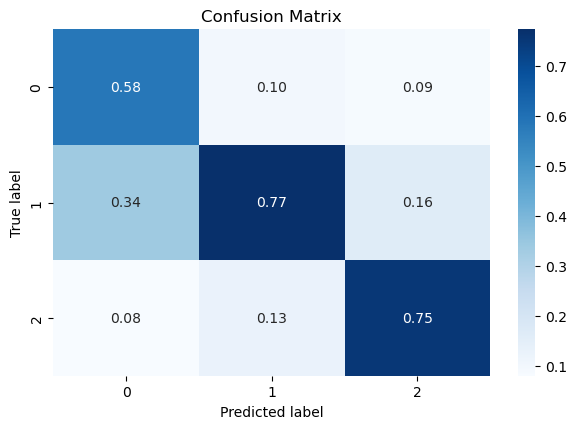

The overall accuracy is: 0.6844
The precision score is: 0.7014
The recall score is: 0.6844
The F1 score is: 0.6687
The AUC score is: 0.8686

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.82      0.68       132
           1       0.77      0.40      0.52       154
           2       0.75      0.85      0.80       164

    accuracy                           0.68       450
   macro avg       0.70      0.69      0.67       450
weighted avg       0.71      0.68      0.67       450



In [77]:
evaluate_model_performance(model_dnn, x_test, y_test)

***

## k-fold DNN

In [51]:
class Args_kfold:
    # arugments
    epochs=300
    bs=32
    lr=0.0001
    momentum=0.9
    num_classes= 3
    split=5
    seed=710674

args_kfold = Args_kfold()

In [52]:
class kfoldMLP:
    def __init__(self, input_dim, layer_configs, output_units, output_activation='softmax'):
        self.input_dim = input_dim
        self.layer_configs = layer_configs
        self.output_units = output_units
        self.output_activation = output_activation
        self.callbacks = []
        self.model = None
        
    def build_model(self):
        model = models.Sequential()
        
        ## add first hidden layer
        model.add(layers.Dense(units=self.layer_configs[0]['units'], 
                               activation=self.layer_configs[0]['activation'], 
                               input_shape=(self.input_dim,)))
        
        ## batch normalization and dropout for first layer
        if self.layer_configs[0].get('batch_norm', False):
            model.add(layers.BatchNormalization())
        
        if self.layer_configs[0].get('dropout_rate', None) is not None:
            model.add(layers.Dropout(rate=self.layer_configs[0]['dropout_rate']))
        
        ## do same for rest hidden layers (except for the last)
        for config in self.layer_configs[1:]:
            model.add(layers.Dense(units=config['units'], activation=config['activation']))
            
            if config.get('batch_norm', False):
                model.add(layers.BatchNormalization())
            
            if config.get('dropout_rate', None) is not None:
                model.add(layers.Dropout(rate=config['dropout_rate']))
        
        ## add output layer
        model.add(layers.Dense(units=self.output_units, activation=self.output_activation))
        self.model = model

    ## model compile
    def compile_model(self, optimizer, loss='categorical_crossentropy', metrics=['accuracy'], lr_scheduler=None):
        if lr_scheduler:
            self.callbacks.append(tf.keras.callbacks.LearningRateScheduler(lr_scheduler))

        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def fit_model(self, x_train, y_train, epochs, batch_size, validation_data=None, class_weight=None, verbose=0):
        return self.model.fit(
            x_train, y_train, 
            epochs=epochs, 
            batch_size=batch_size, 
            validation_data=validation_data, 
            callbacks=self.callbacks, 
            class_weight=class_weight,
            verbose=verbose
        )

    def evaluate_model(self, x_test, y_test):
        return self.model.evaluate(x_test, y_test)

    def predict(self, x):
        y_pred = self.model.predict(x)
        return np.array(y_pred)

    def summary(self):
        self.model.summary()

    def cross_validate(self, x_data, y_data, n_splits, epochs, batch_size, optimizer=None, class_weight=None):
        x_data = np.array(x_data)
        y_data = np.array(y_data)
        kf = KFold(n_splits=n_splits, shuffle=True) ##set fold split and shuffle
        fold_metrics = []

        for fold, (train_index, val_index) in enumerate(kf.split(x_data), 1):
            x_train, x_val = x_data[train_index], x_data[val_index]
            y_train, y_val = y_data[train_index], y_data[val_index]

            ## build new model
            self.build_model()
            self.compile_model(optimizer=optimizer)
            
            ## model training
            self.fit_model(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), class_weight=class_weight, verbose=0)
            
            ## evaluate the model
            y_val_pred = self.predict(x_val)
            if isinstance(y_val_pred, list):
                y_val_pred = np.array(y_val_pred)
            y_val_pred = np.argmax(y_val_pred, axis=1)
            y_val_true = np.argmax(y_val, axis=1)
            
            accuracy = accuracy_score(y_val_true, y_val_pred)
            precision = precision_score(y_val_true, y_val_pred, average='macro')
            recall = recall_score(y_val_true, y_val_pred, average='macro')
            f1 = f1_score(y_val_true, y_val_pred, average='weighted')
            auc = roc_auc_score(y_val, self.predict(x_val), multi_class='ovr')
            
            fold_metrics.append({
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'auc': auc
            })

            print(f"Fold metrics: Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={f1:.4f}, AUC={auc:.4f}")
        
        avg_metrics = {key: np.mean([m[key] for m in fold_metrics]) for key in fold_metrics[0].keys()}
        
        print("\nAverage metrics across all folds:")
        for metric, value in avg_metrics.items():
            print(f"{metric.capitalize()}: {value:.4f}")

        return fold_metrics, avg_metrics

    ## evaluation on test dataset (for performance check)
    def evaluate_test_data(self, x_test, y_test):
        y_pred = self.predict(x_test)
        y_pred_labels = np.argmax(y_pred, axis=1)
        y_true_labels = np.argmax(y_test, axis=1)

        # Confusion Matrix
        cm = confusion_matrix(y_true_labels, y_pred_labels, normalize='pred')
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        print("=============================================")

        # Classification Report
        class_report = classification_report(y_true_labels, y_pred_labels, target_names=[f'Class {i}' for i in range(self.output_units)])
        print("Classification Report:\n", class_report)

        return cm, class_report

In [53]:
## model initialization with hidden layer list below
# layer_configs = [
#     {'units': 64, 'activation': 'relu', 'batch_norm': True, 'dropout_rate': 0.5},
#     {'units': 32, 'activation': 'relu', 'batch_norm': True, 'dropout_rate': 0.3},
#     {'units': 32, 'activation': 'relu', 'batch_norm': True},
#     {'units': 16, 'activation': 'relu', 'batch_norm': True, 'dropout_rate': 0.3},
#     {'units': 16, 'activation': 'relu', 'batch_norm': True}
# ]

layer_configs = [
    {'units': 32, 'activation': 'relu', 'batch_norm': True},
    {'units': 64, 'activation': 'relu', 'batch_norm': True, 'dropout_rate': 0.5},
    {'units': 64, 'activation': 'relu', 'batch_norm': True, 'dropout_rate': 0.5},
    {'units': 32, 'activation': 'relu', 'batch_norm': True},
    {'units': 16, 'activation': 'relu', 'batch_norm': True}
]

kfold = kfoldMLP(output_units=args_kfold.num_classes, input_dim=x_train.shape[1], layer_configs=layer_configs)

In [54]:
## compile our model
opt = keras.optimizers.SGD(learning_rate = 0.001, decay = 1e-5, momentum = 0.9)
scheduler = lambda epoch: dynamic_learning_rate(epoch, mode='exp_range', base_lr=0.001, max_lr=0.02, step_size=50)

In [55]:
# K-Fold 교차 검증 실행
metrics, avg_metrics = kfold.cross_validate(x_train, y_train, n_splits=args_kfold.split, optimizer=opt, epochs=args_kfold.epochs, batch_size=args_kfold.bs)

# 각 폴드의 성능 지표 출력
for i, metric in enumerate(metrics):
    print(f"Fold {i+1}: {metric}")

7/7 [==============================] - 0s 2ms/step
Fold metrics: Accuracy=0.7095, Precision=0.7084, Recall=0.7075, F1 Score=0.7100, AUC=0.8820
7/7 [==============================] - 0s 2ms/step
Fold metrics: Accuracy=0.7810, Precision=0.7942, Recall=0.7898, F1 Score=0.7759, AUC=0.9076
7/7 [==============================] - 0s 2ms/step
Fold metrics: Accuracy=0.7000, Precision=0.7001, Recall=0.7094, F1 Score=0.6995, AUC=0.8717
7/7 [==============================] - 0s 2ms/step
Fold metrics: Accuracy=0.6810, Precision=0.6997, Recall=0.6730, F1 Score=0.6698, AUC=0.8391
7/7 [==============================] - 0s 2ms/step
Fold metrics: Accuracy=0.7190, Precision=0.7377, Recall=0.7258, F1 Score=0.7167, AUC=0.8734

Average metrics across all folds:
Accuracy: 0.7181
Precision: 0.7280
Recall: 0.7211
F1_score: 0.7144
Auc: 0.8748
Fold 1: {'accuracy': 0.7095238095238096, 'precision': 0.7083878339133752, 'recall': 0.7075376541947795, 'f1_score': 0.7100072658171249, 'auc': 0.8820472627781438}
Fold 2: 

* Evaluation on test dataset

15/15 [==============================] - 0s 3ms/step


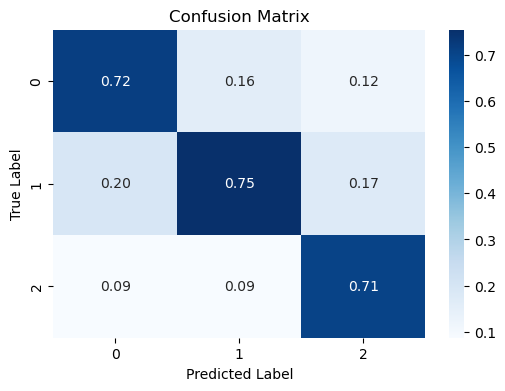

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.72      0.67      0.69       132
     Class 1       0.75      0.62      0.68       154
     Class 2       0.71      0.87      0.78       164

    accuracy                           0.72       450
   macro avg       0.73      0.72      0.72       450
weighted avg       0.73      0.72      0.72       450



In [56]:
cm, class_report = kfold.evaluate_test_data(x_test, y_test)

***

## Multimodal DNN

In [ ]:
class Args_multi:
    # arugments
    epochs=150
    enc_epochs = 50
    bs=32
    enc_bs = 16
    lr=0.0001
    momentum=0.9
    num_classes= 4
    seed=710674

args_multi = Args_multi()

# np.random.seed(args.seed)
# random.seed(args.seed)
# torch.manual_seed(args.seed)

In [ ]:
# data = data_no_s8.copy()
# data = data_fill_s8.copy()
# data = data_nona.copy()
# data = data_fill.copy()
# data = data_fill_mean.copy()
# data = data_fill_mean_age.copy()
data = data_fill_mean_knn.copy()

In [ ]:
data['target_info'].value_counts()

In [ ]:
data.columns

In [ ]:
data_x = data.drop(['subject_info', 'birth_info', 'target_info', 'sex_info', 'age_info', 'family_hx_info', 'marriage_info', 'job_info'], axis=1)
data_y = data.loc[:,["target_info"]]

In [ ]:
# ## this is for selecting variables with JSDivergence big differences
# data_x = data_x[big_diff_columns]

# ## this is for selecting variables without JSDivergence big differences
# # data_x = data_x.drop(big_diff_columns, axis=1)

In [ ]:
data_x = data_x.fillna(data_x.mean())

In [ ]:
########## FULL GROUP CLASSIFICATION ##########
label = data_y
label = label.replace({'control':0})
label = label.replace({'mdd': 1})
label = label.replace({'bpi': 2})
label = label.replace({'bpii': 3})

y = to_categorical(label, 4) ## into the format of one-hot encoding

In [ ]:
############## FOR FOUR-GROUP CLASSIFICATION ###############
# class_weight = {0:1, 1:1.29, 2:3.04, 3: 1.13}
class_weight = {0:1, 1:1.81, 2:4.63, 3: 1.44}
# class_weight = {0:1.15, 1:2.09, 2:2.84, 3: 1}

### using subnetworks

* dataframe contains section 2,4,5,6,7,8

In [ ]:
data_s2 = data_x.iloc[:, (data_x.columns.str.contains(('s2')))]
data_s4 = data_x.iloc[:, (data_x.columns.str.contains(('s4')))]
data_s5 = data_x.iloc[:, (data_x.columns.str.contains(('s5')))]
data_s6 = data_x.iloc[:, (data_x.columns.str.contains(('s6')))]
data_s7 = data_x.iloc[:, (data_x.columns.str.contains(('s7')))]
data_s8 = data_x.iloc[:, (data_x.columns.str.contains(('s8')))]

In [ ]:
# data_s5.columns

In [ ]:
# 입력 정의
input2 = Input(shape=(data_s2.shape[1],))
input4 = Input(shape=(data_s4.shape[1],))
input5 = Input(shape=(data_s5.shape[1],))
input6 = Input(shape=(data_s6.shape[1],))
input7 = Input(shape=(data_s7.shape[1],))
input8 = Input(shape=(data_s8.shape[1],))

---

* Creating commonly using sub-network

In [ ]:
# 서브 네트워크 정의 함수
def create_subnetwork(input_layer):
    x = Dense(32, activation='relu')(input_layer)
    # x = Dense(16, activation='relu')(x)
    x = BatchNormalization()(x)
    # x = Dropout(0.3)(x)
    x = Dense(8, activation='relu')(x)
    return x

In [ ]:
# 서브 네트워크 생성
subnet2 = create_subnetwork(input2)
subnet4 = create_subnetwork(input4)
subnet5 = create_subnetwork(input5)
subnet6 = create_subnetwork(input6)
subnet7 = create_subnetwork(input7)
subnet8 = create_subnetwork(input8)

=======================================================================================================

In [ ]:
input8

In [ ]:
# 서브 네트워크 정의 함수
def create_subnetwork2(input_layer):
    x = Dense(32, activation='relu')(input_layer)
    x = Dense(8, activation='relu')(x)
    return x

def create_subnetwork4(input_layer):
    x = Dense(16, activation='relu')(input_layer)
    x = Dense(8, activation='relu')(x)
    return x

def create_subnetwork5(input_layer):
    x = Dense(32, activation='relu')(input_layer)
    # x = Dense(32, activation='relu')(x)
    x = Dense(8, activation='relu')(x)
    return x

def create_subnetwork6(input_layer):
    x = Dense(32, activation='relu')(input_layer)
    # x = Dense(64, activation='relu')(x)
    # x = Dense(32, activation='relu')(x)
    x = Dense(8, activation='relu')(x)
    return x

def create_subnetwork7(input_layer):
    x = Dense(32, activation='relu')(input_layer)
    # x = Dense(32, activation='relu')(x)
    x = Dense(8, activation='relu')(x)
    return x

def create_subnetwork8(input_layer):
    x = Dense(16, activation='relu')(input_layer)
    x = Dense(8, activation='relu')(x)
    return x

In [ ]:
# 서브 네트워크 생성
subnet2 = create_subnetwork2(input2)
subnet4 = create_subnetwork4(input4)
subnet5 = create_subnetwork5(input5)
subnet6 = create_subnetwork6(input6)
subnet7 = create_subnetwork7(input7)
subnet8 = create_subnetwork8(input8)

***

In [ ]:
# 서브 네트워크 출력 결합
# combined = Concatenate()([subnet2, subnet4, subnet5, subnet6, subnet7])
combined = Concatenate()([subnet2, subnet4, subnet5, subnet6, subnet7, subnet8])

In [ ]:
combined

In [ ]:
## adding dense(fc) layers after encoder combining
concat_x = Dense(32, activation='relu')(combined)
concat_x = BatchNormalization()(concat_x)
concat_x = Dropout(0.5)(concat_x)
# concat_x = Dense(16, activation='relu')(concat_x)
# concat_x = BatchNormalization()(concat_x)
# concat_x = Dropout(0.5)(concat_x)
# concat_x = Dense(16, activation='relu')(concat_x)
concat_x = Dense(8, activation='relu')(concat_x)

# 최종 출력 레이어 정의 (4-class 분류)
final_output = Dense(args_multi.num_classes, activation='softmax')(concat_x)

In [ ]:
# # 최종 출력 레이어 정의
# final_output = Dense(args_multi.num_classes, activation='softmax')(combined) 

In [ ]:
# x2_train, x2_test, x4_train, x4_test, x5_train, x5_test, x6_train, x6_test, x7_train, x7_test, y_train, y_test = train_test_split(
#     data_s2, data_s4, data_s5, data_s6, data_s7, y, test_size=0.2, random_state=710674)

x2_train, x2_test, x4_train, x4_test, x5_train, x5_test, x6_train, x6_test, x7_train, x7_test, x8_train, x8_test, y_train, y_test = train_test_split(
    data_s2, data_s4, data_s5, data_s6, data_s7, data_s8, y, test_size=0.2, random_state=710674)

In [ ]:
# LearningRateScheduler 설정
lr_scheduler = LearningRateScheduler(lambda epoch: cyclic_learning_rate(epoch, base_lr=0.01, max_lr=0.006, step_size=300))
# lr_scheduler = LearningRateScheduler(lambda epoch: exp_range_lr(epoch, base_lr=0.01, max_lr=0.006, step_size=300, gamma=0.99994))

In [ ]:
opt = keras.optimizers.SGD(learning_rate = args_multi.lr, decay = 1e-6, momentum = args_multi.momentum)

In [ ]:
# 모델 생성 및 컴파일
# model = Model(inputs=[input2, input4, input5, input6, input7], outputs=final_output)
model = Model(inputs=[input2, input4, input5, input6, input7, input8], outputs=final_output)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
# model.fit([data_s2, data_s4, data_s5, data_s6, data_s7, data_s8], y, 
#           epochs=args_multi.epochs, batch_size=args_multi.bs, verbose=2)

# model.fit([x2_train, x4_train, x5_train, x6_train, x7_train, x8_train], y_train, 
#           epochs=args_multi.epochs, batch_size=args_multi.bs, verbose=2)


#########################################

# model.fit([x2_train, x4_train, x5_train, x6_train, x7_train], y_train, 
#           epochs=args_multi.epochs, batch_size=args_multi.bs, callbacks=[lr_scheduler], verbose=2)
model.fit([x2_train, x4_train, x5_train, x6_train, x7_train, x8_train], y_train, 
          epochs=args_multi.epochs, batch_size=args_multi.bs, callbacks=[lr_scheduler], verbose=2)

In [ ]:
# y_predict = model.predict([x2_test, x4_test, x5_test, x6_test, x7_test])
y_predict = model.predict([x2_test, x4_test, x5_test, x6_test, x7_test, x8_test])

y_predict = np.argmax(y_predict, axis = 1)
y_test = np.argmax(y_test, axis = 1)

result = confusion_matrix(y_test, y_predict, normalize = 'pred')
print(result)

In [ ]:
figure = plt.figure(figsize=(6, 4))
sns.heatmap(result, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
accuracy = metrics.accuracy_score(y_test, y_predict)
precision = metrics.precision_score(y_test, y_predict, average = 'macro')
recall = metrics.recall_score(y_test, y_predict, average = 'micro')
f1 = metrics.f1_score(y_test, y_predict, average = 'weighted')
# auc = roc_auc_score(y_test,model.predict([x2_test, x4_test, x5_test, x6_test, x7_test], verbose=0), multi_class='ovr')
auc = roc_auc_score(y_test,model.predict([x2_test, x4_test, x5_test, x6_test, x7_test, x8_test], verbose=0), multi_class='ovr')

print("=============================================")
print("The overall accuracy is:", round(accuracy, 4))
print("The precision score is:", round(precision, 4))
print("The recall score is:", round(recall, 4))
print("The f1 score is:", round(f1, 4))
print("The AUC score is:", round(auc, 4))
print("=============================================")

***

***

### using individual autoencoder

In [ ]:
x2_train, x2_test, x4_train, x4_test, x5_train, x5_test, x6_train, x6_test, x7_train, x7_test, x8_train, x8_test, y_train, y_test = train_test_split(
    data_s2, data_s4, data_s5, data_s6, data_s7, data_s8, y, test_size=0.2, random_state=710674)

***

* Using same autoencoder structure for all input datasets

In [ ]:
## Defining autoencoder
def create_autoencoder(input_shape):
    # defining encoder model
    input_layer = Input(shape=input_shape)
    encoded = Dense(32, activation='relu')(input_layer)
    # encoded = Dense(16, activation='relu')(encoded)
    encoded = Dense(8, activation='relu')(encoded)
    
    # defining decoder model
    # decoded = Dense(16, activation='relu')(encoded)
    decoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(input_shape[0], activation='sigmoid')(decoded)
    
    # setting autoencoder model
    autoencoder = Model(input_layer, decoded)
    
    # extracting encoder model separately
    encoder = Model(input_layer, encoded)
    
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder, encoder

In [ ]:
# Defining input dataset shape
input_shape2 = (data_s2.shape[1],)
input_shape4 = (data_s4.shape[1],)
input_shape5 = (data_s5.shape[1],)
input_shape6 = (data_s6.shape[1],)
input_shape7 = (data_s7.shape[1],)
input_shape8 = (data_s8.shape[1],)

In [ ]:
autoencoder2, encoder2 = create_autoencoder(input_shape2)
autoencoder4, encoder4 = create_autoencoder(input_shape4)
autoencoder5, encoder5 = create_autoencoder(input_shape5)
autoencoder6, encoder6 = create_autoencoder(input_shape6)
autoencoder7, encoder7 = create_autoencoder(input_shape7)
autoencoder8, encoder8 = create_autoencoder(input_shape8)

==========================================

* Using individually difference structured autoencoder model

In [ ]:
# Defining input dataset shape
input_shape2 = (data_s2.shape[1],)
input_shape4 = (data_s4.shape[1],)
input_shape5 = (data_s5.shape[1],)
input_shape6 = (data_s6.shape[1],)
input_shape7 = (data_s7.shape[1],)
input_shape8 = (data_s8.shape[1],)

In [ ]:
input_shape8

In [ ]:
## Defining autoencoder
def create_autoencoder2(input_shape):
    # defining encoder model
    input_layer = Input(shape=input_shape)
    encoded = Dense(64, activation='relu')(input_layer)
    encoded = Dense(16, activation='relu')(encoded)
    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(input_shape[0], activation='sigmoid')(decoded)
    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

def create_autoencoder4(input_shape):
    # defining encoder model
    input_layer = Input(shape=input_shape)
    encoded = Dense(16, activation='relu')(input_layer)
    encoded = Dense(4, activation='relu')(encoded)
    decoded = Dense(16, activation='relu')(encoded)
    decoded = Dense(input_shape[0], activation='sigmoid')(decoded)
    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

def create_autoencoder5(input_shape):
    # defining encoder model
    input_layer = Input(shape=input_shape)
    encoded = Dense(64, activation='relu')(input_layer)
    encoded = Dense(16, activation='relu')(encoded)
    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(input_shape[0], activation='sigmoid')(decoded)
    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

def create_autoencoder6(input_shape):
    # defining encoder model
    input_layer = Input(shape=input_shape)
    encoded = Dense(64, activation='relu')(input_layer)
    encoded = Dense(16, activation='relu')(encoded)
    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(input_shape[0], activation='sigmoid')(decoded)
    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

def create_autoencoder7(input_shape):
    # defining encoder model
    input_layer = Input(shape=input_shape)
    encoded = Dense(64, activation='relu')(input_layer)
    encoded = Dense(16, activation='relu')(encoded)
    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(input_shape[0], activation='sigmoid')(decoded)
    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

def create_autoencoder8(input_shape):
    # defining encoder model
    input_layer = Input(shape=input_shape)
    encoded = Dense(16, activation='relu')(input_layer)
    encoded = Dense(4, activation='relu')(encoded)
    decoded = Dense(16, activation='relu')(encoded)
    decoded = Dense(input_shape[0], activation='sigmoid')(decoded)
    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

In [ ]:
autoencoder2, encoder2 = create_autoencoder2(input_shape2)
autoencoder4, encoder4 = create_autoencoder4(input_shape4)
autoencoder5, encoder5 = create_autoencoder5(input_shape5)
autoencoder6, encoder6 = create_autoencoder6(input_shape6)
autoencoder7, encoder7 = create_autoencoder7(input_shape7)
autoencoder8, encoder8 = create_autoencoder8(input_shape8)

***

In [ ]:
# Training autoencoder model
# autoencoder2.fit(x2_train, x2_train, epochs=args_multi.enc_epochs, batch_size=args_multi.enc_bs)
# autoencoder4.fit(x4_train, x4_train, epochs=args_multi.enc_epochs, batch_size=args_multi.enc_bs)
# autoencoder5.fit(x5_train, x5_train, epochs=args_multi.enc_epochs, batch_size=args_multi.enc_bs)
# autoencoder6.fit(x6_train, x6_train, epochs=args_multi.enc_epochs, batch_size=args_multi.enc_bs)
# autoencoder7.fit(x7_train, x7_train, epochs=args_multi.enc_epochs, batch_size=args_multi.enc_bs)
# autoencoder8.fit(x8_train, x8_train, epochs=args_multi.enc_epochs, batch_size=args_multi.enc_bs)

# Training autoencoder model
autoencoder2.fit(x2_train, x2_train, epochs=args_multi.enc_epochs, batch_size=args_multi.enc_bs, validation_split=0.2)
autoencoder4.fit(x4_train, x4_train, epochs=args_multi.enc_epochs, batch_size=args_multi.enc_bs, validation_split=0.2)
autoencoder5.fit(x5_train, x5_train, epochs=args_multi.enc_epochs, batch_size=args_multi.enc_bs, validation_split=0.2)
autoencoder6.fit(x6_train, x6_train, epochs=args_multi.enc_epochs, batch_size=args_multi.enc_bs, validation_split=0.2)
autoencoder7.fit(x7_train, x7_train, epochs=args_multi.enc_epochs, batch_size=args_multi.enc_bs, validation_split=0.2)
autoencoder8.fit(x8_train, x8_train, epochs=args_multi.enc_epochs, batch_size=args_multi.enc_bs, validation_split=0.2)

In [ ]:
# Defining input
input2 = Input(shape=(data_s2.shape[1],))
input4 = Input(shape=(data_s4.shape[1],))
input5 = Input(shape=(data_s5.shape[1],))
input6 = Input(shape=(data_s6.shape[1],))
input7 = Input(shape=(data_s7.shape[1],))
input8 = Input(shape=(data_s8.shape[1],))

In [ ]:
# Defining subnetwork function
def create_encoded_output(input_layer, encoder):
    return encoder(input_layer)

In [ ]:
# 서브 네트워크 생성
encoded2 = create_encoded_output(input2, encoder2)
encoded4 = create_encoded_output(input4, encoder4)
encoded5 = create_encoded_output(input5, encoder5)
encoded6 = create_encoded_output(input6, encoder6)
encoded7 = create_encoded_output(input7, encoder7)
encoded8 = create_encoded_output(input8, encoder8)

In [ ]:
# 서브 네트워크 출력 결합
combined = Concatenate()([encoded2, encoded4, encoded5, encoded6, encoded7, encoded8])

In [ ]:
combined

In [ ]:
## adding dense(fc) layers after encoder combining
concat_x = Dense(32, activation='relu')(combined)
# concat_x = Dense(64, activation='relu')(concat_x)
concat_x = BatchNormalization()(concat_x)
concat_x = Dropout(0.5)(concat_x)
# concat_x = Dense(32, activation='relu')(concat_x)
# concat_x = Dropout(0.2)(concat_x)
concat_x = Dense(8, activation='relu')(concat_x)

# 최종 출력 레이어 정의 (4-class 분류)
final_output = Dense(args_multi.num_classes, activation='softmax')(concat_x)

In [ ]:
# 모델 생성 및 컴파일
model = Model(inputs=[input2, input4, input5, input6, input7, input8], outputs=final_output)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 요약 출력
model.summary()

In [ ]:
# LearningRateScheduler 설정
lr_scheduler = LearningRateScheduler(lambda epoch: cyclic_learning_rate(epoch, base_lr=0.01, max_lr=0.006, step_size=300))
# lr_scheduler = LearningRateScheduler(lambda epoch: exp_range_lr(epoch, base_lr=0.01, max_lr=0.006, step_size=300, gamma=0.99994))

In [ ]:
## Model training
# model.fit([x2_train, x4_train, x5_train, x6_train, x7_train, x8_train], y_train, epochs=args_multi.epochs, batch_size=args_multi.bs)
model.fit([x2_train, x4_train, x5_train, x6_train, x7_train, x8_train], y_train, epochs=args_multi.epochs, callbacks = [lr_scheduler], batch_size=args_multi.bs)

## Model evaluation
# loss, accuracy = model.evaluate([x2_test, x4_test, x5_test, x6_test, x7_test, x8_test], y_test)
# print(f"Test Accuracy: {accuracy:.4f}")

In [ ]:
y_predict = model.predict([x2_test, x4_test, x5_test, x6_test, x7_test, x8_test])
y_predict = np.argmax(y_predict, axis = 1)
y_test = np.argmax(y_test, axis = 1)

result = confusion_matrix(y_test, y_predict, normalize = 'pred')
print(result)

In [ ]:
figure = plt.figure(figsize=(6, 4))
sns.heatmap(result, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
accuracy = metrics.accuracy_score(y_test, y_predict)
precision = metrics.precision_score(y_test, y_predict, average = 'macro')
recall = metrics.recall_score(y_test, y_predict, average = 'micro')
f1 = metrics.f1_score(y_test, y_predict, average = 'weighted')
auc = roc_auc_score(y_test,model.predict([x2_test, x4_test, x5_test, x6_test, x7_test, x8_test], verbose=0), multi_class='ovr')

print("=============================================")
print("The overall accuracy is:", round(accuracy, 4))
print("The precision score is:", round(precision, 4))
print("The recall score is:", round(recall, 4))
print("The f1 score is:", round(f1, 4))
print("The AUC score is:", round(auc, 4))
print("=============================================")

***

## VAE augmentation

In [ ]:
data = df_reduced.copy()

> We sampled 300 data for each label, to augment other 100 data for each class. \
> This is to compare the classification performance of data augmentation.

In [ ]:
data = data.groupby('condition').apply(lambda x: x.sample(400)).reset_index(drop=True)

In [ ]:
data["condition"].value_counts()

In [ ]:
data_int = data[data['condition']=="interruption"]
data_nos = data[data['condition']=="no stress"]
data_tip = data[data['condition']=="time pressure"]

In [ ]:
class Args_aug:
    # arugments
    epochs=150
    bs=32
    lr=0.0001
    momentum=0.9
    num_classes= 2
    latent_dim = 16
    inter_dim1 = 32
    inter_dim2 = 16
    seed=710674

args_aug = Args_aug()

# np.random.seed(args.seed)
# random.seed(args.seed)
# torch.manual_seed(args.seed)

In [ ]:
# data_vae = data.copy()
# data_vae = data_int.copy()
# data_vae = data_nos.copy()
data_vae = data_tip.copy()

In [ ]:
data_vae.columns

In [ ]:
# y includes our labels and x includes our features
y = data_vae.condition  # M or B 
list = ['condition']
x = data_vae.drop(list, axis = 1 )

In [ ]:
data_x = x.copy()

In [ ]:
scaler = MinMaxScaler() #set the scaler (between 0 and 1)

data_x[:] = scaler.fit_transform(data_x[:])
data_x = data_x.round(decimals=6)

In [ ]:
# # 데이터 확인
# print(np.isnan(data_x).any())  # False여야 합니다.
# print(np.isinf(data_x).any())  # False여야 합니다.

In [ ]:
# data_x = data_x.fillna(data_x.mean())

In [ ]:
########## FULL GROUP CLASSIFICATION ##########
label = y
label = label.replace({'interruption':0})
label = label.replace({'no stress': 1})
label = label.replace({'time pressure': 2})

data_y = to_categorical(label, 3) ## into the format of one-hot encoding

In [ ]:
print("The size of x dataset is:", data_x.shape)
print("The size of y dataset is:", data_y.shape)

### encoder networks

In [ ]:
# ## shallow model
# input_dim = data_x.shape[1]
# latent_dim = 2

# inputs = Input(shape=(input_dim,))
# h = Dense(32, activation='relu')(inputs)
# z_mean = Dense(latent_dim)(h)
# z_log_var = Dense(latent_dim)(h)

In [ ]:
## deeper model
input_dim = data_x.shape[1]
latent_dim = 8

inputs = Input(shape=(input_dim,))
h = Dense(64, activation='relu')(inputs)
h = Dense(32, activation='relu')(h)
h = Dense(16, activation='relu')(h)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [ ]:
## latent space sampling
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

### decoder networks

In [ ]:
# ## shallow model
# decoder_h = Dense(32, activation='relu')
# decoder_mean = Dense(input_dim, activation='sigmoid')

# h_decoded = decoder_h(z)
# x_decoded_mean = decoder_mean(h_decoded)

In [ ]:
## deeper model
decoder_h1 = Dense(16, activation='relu')
decoder_h2 = Dense(32, activation='relu')
decoder_h3 = Dense(64, activation='relu')
decoder_mean = Dense(input_dim, activation='sigmoid')

h_decoded = decoder_h1(z)
h_decoded = decoder_h2(h_decoded)
h_decoded = decoder_h3(h_decoded)
x_decoded_mean = decoder_mean(h_decoded)

### model define

In [ ]:
vae = Model(inputs, x_decoded_mean)
vae.summary()

### loss function

In [ ]:
reconstruction_loss = MeanSquaredError()(inputs, x_decoded_mean)

kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var + K.epsilon()), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

In [ ]:
vae.compile(optimizer=Adam(learning_rate=args_aug.lr))

In [ ]:
vae.summary()

### model training

In [ ]:
vae.fit(data_x, epochs=args_aug.epochs, batch_size=args_aug.bs, validation_split=0.2, verbose=2)

### extracting encoder, decoder

In [ ]:
## encoder model extraction
encoder = Model(inputs, z_mean)

In [ ]:
# ## decoder model extraction
# ## shallow model
# decoder_input = Input(shape=(latent_dim,))
# _h_decoded = decoder_h(decoder_input)
# _x_decoded_mean = decoder_mean(_h_decoded)
# decoder = Model(decoder_input, _x_decoded_mean)

## deeper model
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h1(decoder_input)
_h_decoded = decoder_h2(_h_decoded)
_h_decoded = decoder_h3(_h_decoded)
_x_decoded_mean = decoder_mean(_h_decoded)
decoder = Model(decoder_input, _x_decoded_mean)

In [ ]:
# # 입력 데이터를 잠재 공간으로 인코딩
# encoded_data = encoder.predict(data_x)

# # 잠재 공간의 데이터를 디코딩하여 원래 공간으로 복원
# decoded_data = decoder.predict(encoded_data)

### Latent space visualization

In [ ]:
## encode the input dataset into latent space
encoded_data = encoder.predict(data_x)

## latent space transform with t-SNE function
tsne = TSNE(n_components=2, random_state=710674)
encoded_data_tsne = tsne.fit_transform(encoded_data)

## visualize
plt.figure(figsize=(8, 6))
plt.scatter(encoded_data_tsne[:, 0], encoded_data_tsne[:, 1], c=label, cmap='viridis')
plt.colorbar()
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.title("t-SNE visualization of the latent space")
plt.show()

### Synthetic data generation

In [ ]:
### sampling randomly from latent space
n_samples = 100  # number of synthetic dataset to generate

z_samples = np.random.normal(size=(n_samples, latent_dim))

### 디코더를 통해 synthetic data 생성
# synthetic_data_int = decoder.predict(z_samples)
# synthetic_data_nos = decoder.predict(z_samples)
synthetic_data_tip = decoder.predict(z_samples)

In [ ]:
# gen_int = synthetic_data_int.copy()
# gen_int = pd.DataFrame(gen_int, columns=data_x.columns)

# #####################
# gen_nos = synthetic_data_nos.copy()
# gen_nos = pd.DataFrame(gen_nos, columns=data_x.columns)

#####################
gen_tip = synthetic_data_tip.copy()
gen_tip = pd.DataFrame(gen_tip, columns=data_x.columns)

### performance comparison

#### using original + generated dataset

* Set target information into newly generated dataset

In [ ]:
gen_int['condition'] = "interruption"
gen_nos['condition'] = "no stress"
gen_tip['condition'] = "time pressure"

* Preparing original dataset

In [ ]:
data.shape

In [ ]:
data_int = data[data['condition']=="interruption"]
data_nos = data[data['condition']=="no stress"]
data_tip = data[data['condition']=="time pressure"]

* Concat the original datasets into one original dataframe

In [ ]:
ori_df_list = [data_int, data_nos, data_tip]
ori_df_concat = pd.concat(ori_df_list, ignore_index=True)

In [ ]:
ori_df_concat.shape

In [ ]:
ori_df_concat['condition'].value_counts()

* Concat the generated datasets into one gen dataframe

In [ ]:
gen_df_list = [gen_int, gen_nos, gen_tip]
gen_df_concat = pd.concat(gen_df_list, ignore_index=True)

In [ ]:
gen_df_concat['condition'].value_counts()

* Preparing x and y data vectors

In [ ]:
### Using MDD,BP dataset
ori_x = ori_df_concat.drop(['condition'], axis=1)
ori_y = ori_df_concat.loc[:,["condition"]]

gen_x = gen_df_concat.drop(['condition'], axis=1)
gen_y = gen_df_concat.loc[:,["condition"]]

In [ ]:
ori_x = ori_x.fillna(ori_x.mean())

In [ ]:
label = ori_y
label = label.replace({'interruption':0})
label = label.replace({'no stress': 1})
label = label.replace({'time pressure': 2})

y_ori = to_categorical(label, 3) ## into the format of one-hot encoding

In [ ]:
label_ = gen_y
label_ = label_.replace({'interruption':0})
label_ = label_.replace({'no stress': 1})
label_ = label_.replace({'time pressure': 2})

y_gen = to_categorical(label_, 3) ## into the format of one-hot encoding

* Separating the test dataset only from original dataframe

In [ ]:
x_trainset, x_test, y_trainset, y_test = train_test_split(ori_x, y_ori, test_size = 0.35, random_state = 710674)

* Then concat the generated dataset with training dataset

In [ ]:
x_train_concat = pd.concat([x_trainset, gen_x], ignore_index=True)
y_train_concat = np.concatenate([y_trainset, y_gen])

* Then separating the validation dataset from concat dataframe

In [ ]:
x_train, x_vali, y_train, y_vali = train_test_split(x_train_concat, y_train_concat, test_size = 0.3, random_state = 710674)

In [ ]:
############## FOR FOUR-GROUP CLASSIFICATION ###############
class_weight = {0:1, 1:1, 2:1}

In [ ]:
#### Generate the model
## this model is adequate for full variables usage
model = Sequential()
model.add(Dense(64, input_dim = x_train.shape[1], activation = 'relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(args.num_classes, activation = 'softmax'))

* optimization function, model compile, and model training

In [ ]:
opt = keras.optimizers.SGD(learning_rate = args.lr, decay = 1e-5, momentum = args.momentum)

In [ ]:
# LearningRateScheduler 설정
# lr_scheduler = LearningRateScheduler(lambda epoch: cyclic_learning_rate(epoch, base_lr=0.01, max_lr=0.006, step_size=300))
lr_scheduler = LearningRateScheduler(lambda epoch: exp_range_lr(epoch, base_lr=0.01, max_lr=0.006, step_size=30, gamma=0.99994))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# history = model.fit(x_train, y_train, epochs=args.epochs, batch_size=args.bs, verbose=2)   ## using no class weight
# history = model.fit(x_train, y_train, epochs=args.epochs, batch_size=args.bs, verbose=2, class_weight = class_weight)  ## using class weight
history = model.fit(x_train, y_train, epochs=args.epochs, batch_size=args.bs, callbacks=[lr_scheduler], 
                    validation_data = (x_vali, y_vali), class_weight = class_weight, verbose=2) ## using LR scheduler callback

***

In [ ]:
y_predict = model.predict(x_test)
y_predict = np.argmax(y_predict, axis = 1)
y_test = np.argmax(y_test, axis = 1)

result = confusion_matrix(y_test, y_predict, normalize = 'pred')
print(result)

In [ ]:
figure = plt.figure(figsize=(6, 4))
sns.heatmap(result, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
accuracy = metrics.accuracy_score(y_test, y_predict)
precision = metrics.precision_score(y_test, y_predict, average = 'macro')
recall = metrics.recall_score(y_test, y_predict, average = 'micro')
f1 = metrics.f1_score(y_test, y_predict, average = 'weighted')
auc = roc_auc_score(y_test, model.predict(x_test, verbose=0), multi_class='ovr')

print("=============================================")
print("The overall accuracy is:", round(accuracy, 4))
print("The precision score is:", round(precision, 4))
print("The recall score is:", round(recall, 4))
print("The f1 score is:", round(f1, 4))
print("The AUC score is:", round(auc, 4))
print("=============================================")

***

## VAE + DNN?

### data preparation

In [ ]:
data = df_reduced.copy()
# data = data.groupby('condition').apply(lambda x: x.sample(300)).reset_index(drop=True)

In [ ]:
data_int = data[data['condition']=="interruption"]
data_nos = data[data['condition']=="no stress"]
data_tip = data[data['condition']=="time pressure"]

In [ ]:
class Args_vaednn:
    # arugments
    epochs=150
    bs=32
    lr=0.0001
    momentum=0.9
    num_classes= 3
    seed=710674

args_vaednn = Args_vaednn()

# np.random.seed(args.seed)
# random.seed(args.seed)
# torch.manual_seed(args.seed)

In [ ]:
data_vae = data.copy()
# data_vae = data_int.copy()
# data_vae = data_nos.copy()
# data_vae = data_tip.copy()

In [ ]:
data_vae.shape

In [ ]:
# y includes our labels and x includes our features
y = data_vae.condition
list = ['condition']
x = data_vae.drop(list, axis = 1 )

In [ ]:
data_x = x.copy()

In [ ]:
scaler = MinMaxScaler() #set the scaler (between 0 and 1)

data_x[:] = scaler.fit_transform(data_x[:])
data_x = data_x.round(decimals=6)

In [ ]:
########## FULL GROUP CLASSIFICATION ##########
label = y
label = label.replace({'interruption':0})
label = label.replace({'no stress': 1})
label = label.replace({'time pressure': 2})

data_y = to_categorical(label, 3) ## into the format of one-hot encoding

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size = 0.2, random_state = 710674)

### model

In [ ]:
input_dim = data_x.shape[1]
latent_dim = 10

In [ ]:
## encoder model for VAE+DNN
def build_encoder(input_dim, latent_dim):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.Dense(32, activation='relu')(x)
    
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(z_log_var) * epsilon

    z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    return Model(inputs, [z_mean, z_log_var, z], name='encoder')

In [ ]:
## decoder model for VAE+DNN
def build_decoder(latent_dim, output_dim):
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(32, activation='relu')(latent_inputs)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(output_dim)(x)
    
    return Model(latent_inputs, outputs, name='decoder')

In [ ]:
## VAE model
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        reconstruction_loss = mse(inputs, reconstructed) * input_dim
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        self.add_loss(K.mean(reconstruction_loss + kl_loss))
        return reconstructed

In [ ]:
encoder = build_encoder(input_dim, latent_dim)
decoder = build_decoder(latent_dim, input_dim)

vae = VAE(encoder, decoder)
vae.compile(optimizer=Adam())

In [ ]:
# VAE 모델 학습
vae.fit(x_train, epochs=args_vaednn.epochs, batch_size=args_vaednn.bs, validation_split=0.2)

In [ ]:
## add fully-connected classifier at the back of the VAE model
def build_vae_with_classifier(vae, input_dim):
    vae_input = layers.Input(shape=(input_dim,))
    vae_output = vae(vae_input)  # output from vae (reconstructed dataset)
    
    ## classifier defining
    x = layers.Dense(64, activation='relu')(vae_output)
    x = layers.Dense(32, activation='relu')(x)
    classifier_output = layers.Dense(args_vaednn.num_classes, activation='softmax')(x)
    
    return Model(vae_input, classifier_output)

## classifier 
opt = keras.optimizers.SGD(learning_rate = args.lr, decay = 1e-5, momentum = args.momentum)
vae_with_classifier = build_vae_with_classifier(vae, input_dim)
vae_with_classifier.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
vae_with_classifier.summary()

In [ ]:
## model training
vae_with_classifier.fit(x_train, y_train, epochs=args_vaednn.epochs, batch_size=args_vaednn.bs)

***

In [ ]:
y_predict = vae_with_classifier.predict(x_test)
y_predict = np.argmax(y_predict, axis = 1)
y_test = np.argmax(y_test, axis = 1)

result = confusion_matrix(y_test, y_predict, normalize = 'pred')
print(result)

In [ ]:
figure = plt.figure(figsize=(6, 4))
sns.heatmap(result, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
accuracy = metrics.accuracy_score(y_test, y_predict)
precision = metrics.precision_score(y_test, y_predict, average = 'macro')
recall = metrics.recall_score(y_test, y_predict, average = 'micro')
f1 = metrics.f1_score(y_test, y_predict, average = 'weighted')
auc = roc_auc_score(y_test, vae_with_classifier.predict(x_test, verbose=0), multi_class='ovr')

print("=============================================")
print("The overall accuracy is:", round(accuracy, 4))
print("The precision score is:", round(precision, 4))
print("The recall score is:", round(recall, 4))
print("The f1 score is:", round(f1, 4))
print("The AUC score is:", round(auc, 4))
print("=============================================")

## VAE + DNN v2

> This model is adding classifier after the encoder section

### model

In [ ]:
input_dim = data_x.shape[1]
latent_dim = 4

In [ ]:
def build_encoder(input_dim, latent_dim):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dense(8, activation='relu')(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
    return models.Model(inputs, [z_mean, z_log_var, z], name="encoder")

In [ ]:
def build_decoder(latent_dim, output_dim):
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(8, activation='relu')(latent_inputs)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(output_dim, activation='softmax')(x)
    return models.Model(latent_inputs, outputs, name="decoder")

In [ ]:
def build_vae(encoder, decoder, input_dim):
    inputs = layers.Input(shape=(input_dim,))
    z_mean, z_log_var, z = encoder(inputs)
    reconstructed = decoder(z)

    reconstruction_loss = tf.reduce_mean(losses.binary_crossentropy(inputs, reconstructed))
    kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    vae_loss = reconstruction_loss + kl_loss

    vae = models.Model(inputs, reconstructed)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    return vae

In [ ]:
def build_classifier(latent_dim, num_classes):
    classifier_input = layers.Input(shape=(latent_dim,))
    x = layers.Dense(64, activation='relu')(classifier_input)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(32, activation='relu')(x)
    classifier_output = layers.Dense(args_vaednn.num_classes, activation='softmax')(x)
    
    classifier = models.Model(classifier_input, classifier_output, name='classifier')
    # classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return classifier

In [ ]:
encoder = build_encoder(input_dim, latent_dim)
decoder = build_decoder(latent_dim, input_dim)
vae = build_vae(encoder, decoder, input_dim)

vae.fit(x_train, epochs=args_vaednn.epochs, batch_size=args_vaednn.bs)

In [ ]:
z_train = encoder.predict(x_train)[2]

classifier = build_classifier(latent_dim, args_vaednn.num_classes)
classifier.fit(z_train, y_train, epochs=args_vaednn.epochs, batch_size=args_vaednn.bs)

In [ ]:
# encoder.predict(x_test)[2]

***

In [ ]:
z_test = encoder.predict(x_test)[2]

In [ ]:
y_predict = classifier.predict(z_test)

In [ ]:
y_predict = np.argmax(y_predict, axis = 1)

In [ ]:
y_test

In [ ]:
z_test = encoder.predict(x_test)[2]

y_predict = classifier.predict(z_test)
y_predict = np.argmax(y_predict, axis = 1)
# y_test = np.argmax(y_test, axis = 1)

result = confusion_matrix(y_test, y_predict, normalize = 'pred')
print(result)

In [ ]:
figure = plt.figure(figsize=(6, 4))
sns.heatmap(result, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
accuracy = metrics.accuracy_score(y_test, y_predict)
precision = metrics.precision_score(y_test, y_predict, average = 'macro')
recall = metrics.recall_score(y_test, y_predict, average = 'micro')
f1 = metrics.f1_score(y_test, y_predict, average = 'weighted')
auc = roc_auc_score(y_test, vae_with_classifier.predict(x_test, verbose=0), multi_class='ovr')

print("=============================================")
print("The overall accuracy is:", round(accuracy, 4))
print("The precision score is:", round(precision, 4))
print("The recall score is:", round(recall, 4))
print("The f1 score is:", round(f1, 4))
print("The AUC score is:", round(auc, 4))
print("=============================================")